In [7]:
# Basic imports
import os
import sys
import time
import timeit
import random
import pickle
import re
from itertools import product
import warnings

# System path modification
sys.path.insert(0, '..')

# Data handling
import pandas as pd
import numpy as np

# Machine learning imports
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer, MissingIndicator
from sklearn.model_selection import (
    train_test_split, KFold, StratifiedKFold, GroupKFold, StratifiedGroupKFold, LeaveOneOut, cross_validate, cross_val_score
)
from sklearn.linear_model import (
    LinearRegression, Lasso, LassoCV, MultiTaskLasso, MultiTaskLassoCV,
    ElasticNet, ElasticNetCV, MultiTaskElasticNet, MultiTaskElasticNetCV
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

from sklearn.cross_decomposition import PLSRegression
from sklearn.inspection import permutation_importance


# Statistic imports 
from scipy.stats import ks_2samp
from scipy.special import kl_div
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist, squareform

# Specialized imputation and visualization packages
import miceforest as mf
import missingno as msno
#from missforest import MissForest
#import magic
from src.gain import *

# Custom modules
from src.train import *
from src.functions import *
from src.plots import *
from src.dataset import *
from src.multixgboost import *
from src.wrapper import *

# Visualizatiokn 
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning and machine learning specific 
import torch
from pytorch_tabnet.tab_model import TabNetRegressor
import xgboost as xgb
import shap

# Ignore warnings
warnings.filterwarnings("ignore")

# Print CUDA availability for PyTorch
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


## Load data 

In [8]:
data = load_pickle_data_palettes()

results_pickle_folder = "../pickle/"

# Unpack data
df_X, df_y, df_all, df_FinalCombination = data["df_X"], data["df_y"], data["df_all"], data["df_FinalCombination"]
dict_select = data["dict_select"]

# Unpack colormaps
full_palette, gender_palette, dx_palette = data["colormaps"].values()

# Leave-One-Missing-Out (LOMO-CV)

In [9]:
idx_na = list(df_X.isna().any(axis=1))
idx_nona = list(~df_X.isna().any(axis=1))

# Identify unique RIDs for rows with and without missing data
rid_na = df_all.loc[idx_na, "RID"].unique()
rid_nona = df_all.loc[idx_nona, "RID"].unique()

# Identify RIDs eligible for test set (not in train set)
eligible_rid_na = np.setdiff1d(rid_na, rid_nona)

df_X[["APOE_epsilon2", "APOE_epsilon3", "APOE_epsilon4"]] = df_X[["APOE_epsilon2", "APOE_epsilon3", "APOE_epsilon4"]].astype("category")


single_measurement_rids = (
    df_all[df_all["RID"].isin(eligible_rid_na)]
    .groupby("RID")
    .filter(lambda x: len(x) == 1)
    .RID.unique()
)

test_rids = np.random.choice(single_measurement_rids, size=20, replace=False)

# Create boolean mask for the test set
idx_test = df_all["RID"].isin(test_rids)

# Create boolean mask for the train set (all not in test)
idx_train = ~idx_test

print(idx_test.sum())

20


In [10]:
random_state=42
n_imputation_iter = 10

# Define hyperparameters
gain_parameters = {
    'hint_rate': 0.9,
    'alpha': 100,
    'iterations': 1000
}

# Continuous Imputer List (list of tuples with unique strings and corresponding instances)
continuous_imputer_list = [
    #("SimpleImputer_mean", SimpleImputer(strategy="mean")),
    ("KNNImputer", KNNImputer(n_neighbors=1)),
]

# Ordinal Imputer List (list of tuples with unique strings and corresponding instances)
ordinal_imputer_list = [
    ("SimpleImputer_most_frequent", SimpleImputer(strategy="most_frequent"))
]

# Predictive Models List (list of tuples with unique strings and corresponding instances)
predictive_models_list = [
    ("LinearRegression", LinearRegression()),
    ("MultiTaskElasticNet", MultiTaskElasticNet()),
    ("MultiTaskElasticNet_tuned", MultiTaskElasticNet(**{'alpha': 0.01, 'l1_ratio': 0.01})),
    ("MultiTaskLasso", MultiTaskLasso()),
    ("MultiTaskLasso_tuned", MultiTaskLasso(**{'alpha': 0.001})),
    ("RandomForestRegressor", RandomForestRegressor()),
    ("XGBoostRegressor", XGBoostRegressor()),
    ("XGBoostRegressor_tuned", XGBoostRegressor(**{'colsample_bytree': 0.5079831261101071, 'learning_rate': 0.0769592094304232, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.8049983288913105})),
    ("TabNetRegressor_default", TabNetModelWrapper(n_a=8, n_d=8)),
    ("TabNetRegressor_custom", TabNetModelWrapper(n_a=32, n_d=32)),
    ("PLSRegression_4_components", PLSRegression(n_components=4))
]

# Generate all combinations
combinations = list(product(continuous_imputer_list, ordinal_imputer_list, predictive_models_list))

# Display all combinations
for continuous_imputer, ordinal_imputer, model in combinations:
    print(f"Continuous Imputer: {continuous_imputer[0]}, Ordinal Imputer: {ordinal_imputer[0]}, Model: {model[0]}")

print(f"Combinations of preprocessing and models to test : {len(combinations)}")

Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: MultiTaskElasticNet
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: MultiTaskElasticNet_tuned
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: MultiTaskLasso
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: MultiTaskLasso_tuned
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: RandomForestRegressor
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: XGBoostRegressor
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: XGBoostRegressor_tuned
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: TabNetRegressor_default
Continuous Imputer: KNNImputer, Ordinal Imputer: S

In [11]:
test_indices = [i for i, val in enumerate(idx_test) if val]

In [12]:
# Initialize HDF5 file
results_file = '../pickle/training_4_loona_dict_results.pickle'

if os.path.exists(results_file): 

    with open(results_file, "rb") as input_file:
        all_dict_results = pickle.load(input_file)

else : 
    all_dict_results = []

for continuous_imputer, ordinal_imputer, model in combinations:
    name_continuous_imputer, continuous_imputer_instance = continuous_imputer
    name_ordinal_imputer, ordinal_imputer_instance = ordinal_imputer
    name_model, model_instance = model

    params = {
            "ordinal_imputer": name_ordinal_imputer, 
            "continuous_imputer": name_continuous_imputer, 
            "model": name_model, "train_shape" : (df_X.shape[0]-1, df_X.shape[1]), 
            "test_shape": (1, df_X.shape[1]),
            "test_rid": df_all.iloc[test_indices]["RID"].tolist()
        }

    # Define the subset of keys you care about
    keys_to_check = ['ordinal_imputer', 'continuous_imputer', 'model']  # or whatever subset you want
    
    # Check if a result in all_dict_results has the same values for just those keys
    if any(all(result['params'].get(k) == params.get(k) for k in keys_to_check) for result in all_dict_results):
        print(f"Skipping existing combination (subset match): {[params[k] for k in keys_to_check]}")
        continue
    
    dict_results = {
            "params": params, 
            "imputation_time": [],
            "fitting_time": [], 
            "results_adj": [], 
            "results_org": []
        }

    for test_nloc in test_indices: 

        idx_train = [True for i in range(df_X.shape[0])]
        idx_test = [False for i in range(df_X.shape[0])]

        idx_test[test_nloc] = True
        idx_train[test_nloc] = False

        df_X_train = df_X.loc[idx_train]
        df_X_test = df_X.loc[idx_test]

        df_y_train = df_y.loc[idx_train]
        df_y_test = df_y.loc[idx_test]

        c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
        c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

        try: 
        
            # Now you can call your `train_model` function with these components
            fold_dict_results = train_imputer_model(
                df_X_train, df_X_test, df_y_train, df_y_test,
                c_train, c_test,
                ordinal_imputer_instance, name_ordinal_imputer,
                continuous_imputer_instance, name_continuous_imputer,
                model_instance, name_model,
                separate_imputers=True  # Or however you want to specify
            )

            dict_results["imputation_time"].append(fold_dict_results["imputation_time"])  
            dict_results["fitting_time"].append(fold_dict_results["fitting_time"])  
            dict_results["results_adj"].append(fold_dict_results["results_adj"])  
            dict_results["results_org"].append(fold_dict_results["results_org"])    

        except Exception as e:  

            print(e)
            
    # Optionally keep the all_dict_results list updated
    all_dict_results.append(dict_results)
    
    # Save the updated results back to the pickle file
    with open(results_file, 'wb') as f:
        pickle.dump(all_dict_results, f)


Using separate imputers for ordinal and continuous data.
Saving predictions in dict!
Using separate imputers for ordinal and continuous data.
Saving predictions in dict!
Using separate imputers for ordinal and continuous data.
Saving predictions in dict!
Using separate imputers for ordinal and continuous data.
Saving predictions in dict!
Using separate imputers for ordinal and continuous data.
Saving predictions in dict!
Using separate imputers for ordinal and continuous data.
Saving predictions in dict!
Using separate imputers for ordinal and continuous data.
Saving predictions in dict!
Using separate imputers for ordinal and continuous data.
Saving predictions in dict!
Using separate imputers for ordinal and continuous data.
Saving predictions in dict!
Using separate imputers for ordinal and continuous data.
Saving predictions in dict!
Using separate imputers for ordinal and continuous data.
Saving predictions in dict!
Using separate imputers for ordinal and continuous data.
Saving p

In [13]:
# Store data (serialize)
with open(results_file, 'wb') as handle:
    pickle.dump(all_dict_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
with open('../pickle/training_4_loona_dict_results.pickle', "rb") as input_file:
    dict_results_loo_na = pickle.load(input_file)

## Add Pytorch Tabular models

# Train models only on MRI features to compare performances

## Option 3 : Leave-one-out with missing values

In [15]:
idx_na = list(df_X.isna().any(axis=1))
idx_nona = list(~df_X.isna().any(axis=1))

# Identify unique RIDs for rows with and without missing data
rid_na = df_all.loc[idx_na, "RID"].unique()
rid_nona = df_all.loc[idx_nona, "RID"].unique()

# Identify RIDs eligible for test set (not in train set)
eligible_rid_na = np.setdiff1d(rid_na, rid_nona)

df_X[["APOE_epsilon2", "APOE_epsilon3", "APOE_epsilon4"]] = df_X[["APOE_epsilon2", "APOE_epsilon3", "APOE_epsilon4"]].astype("category")


single_measurement_rids = (
    df_all[df_all["RID"].isin(eligible_rid_na)]
    .groupby("RID")
    .filter(lambda x: len(x) == 1)
    .RID.unique()
)

test_rids = np.random.choice(single_measurement_rids, size=20, replace=False)

# Create boolean mask for the test set
idx_test = df_all["RID"].isin(test_rids)

# Create boolean mask for the train set (all not in test)
idx_train = ~idx_test

print(idx_test.sum())

20


In [16]:
random_state=42
n_imputation_iter = 10

# Define hyperparameters
gain_parameters = {
    'hint_rate': 0.9,
    'alpha': 100,
    'iterations': 1000
}

# Continuous Imputer List (list of tuples with unique strings and corresponding instances)
continuous_imputer_list = [
    ("NoImputer", KNNImputer(n_neighbors=1)),
]

# Ordinal Imputer List (list of tuples with unique strings and corresponding instances)
ordinal_imputer_list = [
    ("NoImputer", SimpleImputer(strategy="most_frequent"))
]

# Predictive Models List (list of tuples with unique strings and corresponding instances)
predictive_models_list = [
    ("LinearRegression", LinearRegression()),
    ("MultiTaskElasticNet", MultiTaskElasticNet()),
    ("MultiTaskElasticNet_tuned", MultiTaskElasticNet({'alpha': 0.01, 'l1_ratio': 0.01})),
    ("MultiTaskLasso", MultiTaskLasso()),
    ("MultiTaskLasso_tuned", MultiTaskLasso({'alpha': 0.001})),
    ("RandomForestRegressor", RandomForestRegressor()),
    ("XGBoostRegressor", XGBoostRegressor()),
    ("XGBoostRegressor_tuned", XGBoostRegressor({'colsample_bytree': 0.5079831261101071, 'learning_rate': 0.0769592094304232, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.8049983288913105})),
    ("TabNetRegressor_default", TabNetModelWrapper(n_a=8, n_d=8)),
    ("TabNetRegressor_custom", TabNetModelWrapper(n_a=32, n_d=32)),
    ("PLSRegression_4_components", PLSRegression(n_components=4))
]

# Generate all combinations
combinations = list(product(continuous_imputer_list, ordinal_imputer_list, predictive_models_list))

# Display all combinations
for continuous_imputer, ordinal_imputer, model in combinations:
    print(f"Continuous Imputer: {continuous_imputer[0]}, Ordinal Imputer: {ordinal_imputer[0]}, Model: {model[0]}")

print(f"Combinations of preprocessing and models to test : {len(combinations)}")

Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: LinearRegression
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: MultiTaskElasticNet
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: MultiTaskElasticNet_tuned
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: MultiTaskLasso
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: MultiTaskLasso_tuned
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: RandomForestRegressor
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: XGBoostRegressor
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: XGBoostRegressor_tuned
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: TabNetRegressor_default
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: TabNetRegressor_custom
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: PLSRegression_4_components
Combinations of preprocessing and model

In [17]:
test_indices = [i for i, val in enumerate(idx_test) if val]

In [18]:
results_file = '../pickle/training_4_loona_dict_results.pickle'

with open(results_file, "rb") as input_file:
    all_dict_results = pickle.load(input_file)

In [19]:
test_rids = all_dict_results[0]["params"]["test_rid"]

# Create boolean mask for the test set
idx_test = df_all["RID"].isin(test_rids)

# Create boolean mask for the train set (all not in test)
idx_train = ~idx_test

print(idx_test.sum())

test_indices = [i for i, val in enumerate(idx_test) if val]

20


In [20]:
all([results["params"]["test_rid"] == test_rids for results in all_dict_results])

True

In [21]:
len(all_dict_results)

11

In [22]:
test_indices

[34,
 369,
 455,
 501,
 530,
 551,
 908,
 1075,
 1838,
 2033,
 2076,
 2294,
 2346,
 2369,
 2620,
 2709,
 2715,
 2721,
 2813,
 2868]

In [23]:
list(df_all.iloc[test_indices].values)

[array(['Processed', '018_S_0103', 'ADNI1/GO Month 6', 1.5,
        'MPR; ; N3; Scaled', '2006-08-08', 4731, 17664, '018_S_0103',
        'm06', 18, 'LMCI', 87.3, 1, 18, 'Not Hisp/Latino', 'White',
        'Widowed', nan, nan, nan, 5.5, 31.0, 44.0, 10.0, 18.0, 3.0, -1.0,
        0.0, nan, nan, 12.0, 300.0, 15.0, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, '1.5 Tesla MRI',
        'Cross-Sectional FreeSurfer (FreeSurfer Version 4.3)', 119798.0,
        158508.0, 6634.0, 1006560.0, 2986.0, 16106.0, 18781.0, 1853560.0,
        'MCI', -23.2725, -23.2732, '02/02/2006', 1.5, 18.67, 26.67, 8.0,
        24, 14.0, 4.0, 4.0, 100.0, 3.0, 33.0, 166.0, 2.0, -11.8824,
        -12.5274, '1.5 Tesla MRI',
        'Cross-Sectional FreeSurfer (FreeSurfer Version 4.3)', 144303.0,
        7070.0, 1059540.0, 3465.0, 16908.0, 21409.0, 1859650.0, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        '210.9', '142.1', '14.58', nan, nan

In [24]:
idx_train.sum()

2874

In [25]:
idx_test

3       False
4       False
5       False
6       False
7       False
        ...  
7200    False
7201    False
7202    False
7214    False
7217    False
Name: RID, Length: 2894, dtype: bool

In [26]:
for continuous_imputer, ordinal_imputer, model in combinations:
    name_continuous_imputer, continuous_imputer_instance = continuous_imputer
    name_ordinal_imputer, ordinal_imputer_instance = ordinal_imputer
    name_model, model_instance = model

    params = {
            "ordinal_imputer": name_ordinal_imputer, 
            "continuous_imputer": name_continuous_imputer, 
            "model": name_model, "train_shape" : df_X_train.shape, 
            "test_shape": df_X_test.shape,
            "test_rid": list(df_all.iloc[test_indices])
        }

    
    # Define the subset of keys you care about
    keys_to_check = ['ordinal_imputer', 'continuous_imputer', 'model']  # or whatever subset you want
    
    # Check if a result in all_dict_results has the same values for just those keys
    if any(all(result['params'].get(k) == params.get(k) for k in keys_to_check) for result in all_dict_results):
        print(f"Skipping existing combination (subset match): {[params[k] for k in keys_to_check]}")
        continue
    
    dict_results = {
            "params": params, 
            "imputation_time": [],
            "fitting_time": [], 
            "results_adj": [], 
            "results_org": []
        }

    for test_nloc in test_indices: 

        idx_train = [True for i in range(df_X.shape[0])]
        idx_test = [False for i in range(df_X.shape[0])]

        idx_test[test_nloc] = True
        idx_train[test_nloc] = False

        df_X_train = df_X[].loc[idx_train]
        df_X_test = df_X[select_MRIthickness].loc[idx_test]

        df_y_train = df_y.loc[idx_train]
        df_y_test = df_y.loc[idx_test]

        c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
        c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

        try: 
        
            # Now you can call your `train_model` function with these components
            fold_dict_results = train_imputer_model(
                df_X_train, df_X_test, df_y_train, df_y_test,
                c_train, c_test,
                ordinal_imputer_instance, name_ordinal_imputer,
                continuous_imputer_instance, name_continuous_imputer,
                model_instance, name_model,
                separate_imputers=True  # Or however you want to specify
            )

            dict_results["imputation_time"].append(fold_dict_results["imputation_time"])  
            dict_results["fitting_time"].append(fold_dict_results["fitting_time"])  
            dict_results["results_adj"].append(fold_dict_results["results_adj"])  
            dict_results["results_org"].append(fold_dict_results["results_org"])    

        except Exception as e:  

            print(e)
            
    # Optionally keep the all_dict_results list updated
    all_dict_results.append(dict_results)
    
    # Save the updated results back to the pickle file
    with open(results_file, 'wb') as f:
        pickle.dump(all_dict_results, f)


SyntaxError: invalid syntax (2218423288.py, line 39)

In [ ]:
len(all_dict_results)

43

In [ ]:
with open('..pickle/training_4_loona_dict_results.pickle', "rb") as input_file:
    dict_results_loo_na = pickle.load(input_file)

dict_results_loo_na_copy_failed = dict_results_loo_na

In [ ]:
dict_results_loo_na_copy_failed

[{'params': {'ordinal_imputer': 'SimpleImputer_most_frequent',
   'continuous_imputer': 'KNNImputer',
   'model': 'LinearRegression',
   'train_shape': (2893, 261),
   'test_shape': (1, 261),
   'test_rid': [15,
    69,
    88,
    680,
    886,
    957,
    1099,
    1116,
    1276,
    2073,
    4076,
    4170,
    4366,
    4383,
    4441,
    4547,
    4646,
    4679,
    4809,
    5142]},
  'imputation_time': [3.743319511413574,
   3.6071808338165283,
   3.6088316440582275,
   3.5503551959991455,
   3.6759912967681885,
   3.6502671241760254,
   3.7612340450286865,
   3.544062376022339,
   3.640187978744507,
   3.5111892223358154,
   3.6654648780822754,
   3.5460045337677,
   3.7707672119140625,
   3.6405701637268066,
   3.542612075805664,
   3.534588098526001,
   3.6970882415771484,
   3.791170120239258,
   3.581756114959717,
   3.766244411468506],
  'fitting_time': [0.10106253623962402,
   0.07858920097351074,
   0.07788610458374023,
   0.08089184761047363,
   0.07731866836547852

In [ ]:
#with open('..pickle/backup/training_4_loona_dict_results.pickle', "rb") as input_file:
#    dict_results_loo_na = pickle.load(input_file)

In [ ]:
len(dict_results_loo_na)

43

In [ ]:
df_results_na = pd.json_normalize(dict_results_loo_na)

In [ ]:
metrics = ["mse_score", "mae_score", "r2", "explained_variance", "corr"]
results = ["results_adj", "results_org"]

df_results_na = pd.json_normalize(dict_results_loo_na)

def extract_metric(row, metric): 

    y_test = np.concatenate([temp_dict["y_test"] for temp_dict in row])
    y_pred = np.concatenate([temp_dict["y_pred"] for temp_dict in row])

    mse_score, mae_score, r2, explained_variance, corr = compute_all_metrics(y_test=y_test, y_pred=y_pred)

    output = None

    if metric=="mse_score": 
        output=mse_score
    elif metric=="mae_score": 
        output=mae_score
    elif metric=="r2": 
        output=r2        
    elif metric=="explained_variance": 
        output=explained_variance
    elif metric=="corr": 
        output=corr   

    return list(output.T)


In [ ]:
for metric in metrics: 
    df_results_na[f"results_adj.{metric}"] = df_results_na["results_adj"].apply(extract_metric, metric=metric)
    df_results_na[f"results_org.{metric}"] = df_results_na["results_org"].apply(extract_metric, metric=metric)

In [ ]:
for results in ["results_adj", "results_org"]: 
    for metric in metrics: 
        new_cols = list(f"{results}.{metric}." +df_y.columns) 
        new_cols_to_add = df_results_na[f"{results}.{metric}"].apply(pd.Series, index=new_cols)

        df_results_na = pd.concat([df_results_na, new_cols_to_add], axis=1)

In [ ]:
df_results_na.columns

Index(['imputation_time', 'fitting_time', 'results_adj', 'results_org',
       'params.ordinal_imputer', 'params.continuous_imputer', 'params.model',
       'params.train_shape', 'params.test_shape', 'params.test_rid',
       'results_adj.mse_score', 'results_org.mse_score',
       'results_adj.mae_score', 'results_org.mae_score', 'results_adj.r2',
       'results_org.r2', 'results_adj.explained_variance',
       'results_org.explained_variance', 'results_adj.corr',
       'results_org.corr', 'results_adj.mse_score.ADNI_MEM',
       'results_adj.mse_score.ADNI_EF', 'results_adj.mse_score.ADNI_VS',
       'results_adj.mse_score.ADNI_LAN', 'results_adj.mae_score.ADNI_MEM',
       'results_adj.mae_score.ADNI_EF', 'results_adj.mae_score.ADNI_VS',
       'results_adj.mae_score.ADNI_LAN', 'results_adj.r2.ADNI_MEM',
       'results_adj.r2.ADNI_EF', 'results_adj.r2.ADNI_VS',
       'results_adj.r2.ADNI_LAN', 'results_adj.explained_variance.ADNI_MEM',
       'results_adj.explained_variance.ADNI

In [ ]:
df_results_loonona_radar = df_results_na.melt(id_vars=df_results_na.columns[df_results_na.columns.str.startswith("params")].tolist(), value_vars=df_results_na.columns[df_results_na.columns.str.contains("ADNI")].tolist())
df_results_loonona_radar["result_domain"] = df_results_loonona_radar["variable"].apply(lambda x: x.split(".")[0])
df_results_loonona_radar["metric"] = df_results_loonona_radar["variable"].apply(lambda x: x.split(".")[1])

In [ ]:
df_results_loonona_radar["cognitive_domain"] = df_results_loonona_radar["variable"].apply(lambda x: x.split(".")[2])
df_results_loonona_radar = df_results_loonona_radar.drop(columns=["variable"])
df_results_loonona_radar["preprocessing"] =  df_results_loonona_radar[['params.ordinal_imputer', 'params.continuous_imputer']].agg('.'.join, axis=1)

In [ ]:
df_results_loonona_radar["pipeline"] =  df_results_loonona_radar[['params.ordinal_imputer', 'params.continuous_imputer', 'params.model']].agg('.'.join, axis=1)

In [ ]:
df_results_radar_to_latex_pretable(df_results_loonona_radar, result_domain="results_adj", scoring_metric="corr", ascending=False)

,params.ordinal_imputer_,params.continuous_imputer_,params.model_,corr_ADNI_EF,corr_ADNI_LAN,corr_ADNI_MEM,corr_ADNI_VS,mean,std
30,SimpleImputer_constant,KNNImputer,TabNetRegressor_default,0.402,0.692,0.679,0.194,0.492,0.240
40,SimpleImputer_most_frequent,KNNImputer,TabNetRegressor_custom,0.529,0.828,0.493,-0.013,0.459,0.349
7,KNNImputer,KNNImputer,RandomForestRegressor,0.378,0.701,0.717,0.033,0.457,0.323
39,SimpleImputer_most_frequent,KNNImputer,RandomForestRegressor,0.392,0.727,0.754,-0.054,0.455,0.377
31,SimpleImputer_constant,KNNImputer,XGBoostRegressor,0.591,0.707,0.708,-0.197,0.452,0.436
9,KNNImputer,KNNImputer,TabNetRegressor_default,0.487,0.668,0.620,-0.008,0.441,0.310
17,NoImputer,NoImputer,RandomForestRegressor,0.433,0.760,0.682,-0.115,0.440,0.395
20,NoImputer,NoImputer,XGBoostRegressor,0.478,0.669,0.703,-0.093,0.439,0.368
28,SimpleImputer_constant,KNNImputer,RandomForestRegressor,0.408,0.719,0.695,-0.086,0.434,0.374
36,SimpleImputer_most_frequent,KNNImputer,PLSRegression_2_components,0.380,0.671,0.628,-0.022,0.414,0.318


In [ ]:
df_results_radar_to_latex_pretable(df_results_loonona_radar, result_domain="results_adj", scoring_metric="mae_score", ascending=True)

,params.ordinal_imputer_,params.continuous_imputer_,params.model_,mae_score_ADNI_EF,mae_score_ADNI_LAN,mae_score_ADNI_MEM,mae_score_ADNI_VS,mean,std
20,NoImputer,NoImputer,XGBoostRegressor,0.530,0.459,0.473,0.572,0.509,0.052
39,SimpleImputer_most_frequent,KNNImputer,RandomForestRegressor,0.629,0.450,0.425,0.551,0.514,0.094
17,NoImputer,NoImputer,RandomForestRegressor,0.594,0.423,0.490,0.549,0.514,0.074
7,KNNImputer,KNNImputer,RandomForestRegressor,0.644,0.458,0.452,0.524,0.520,0.089
28,SimpleImputer_constant,KNNImputer,RandomForestRegressor,0.596,0.444,0.480,0.565,0.521,0.071
31,SimpleImputer_constant,KNNImputer,XGBoostRegressor,0.578,0.437,0.507,0.566,0.522,0.065
25,SimpleImputer_constant,KNNImputer,PLSRegression_2_components,0.606,0.488,0.499,0.547,0.535,0.054
15,NoImputer,NoImputer,PLSRegression_2_components,0.621,0.480,0.497,0.545,0.536,0.063
36,SimpleImputer_most_frequent,KNNImputer,PLSRegression_2_components,0.609,0.491,0.497,0.547,0.536,0.055
30,SimpleImputer_constant,KNNImputer,TabNetRegressor_default,0.622,0.444,0.521,0.559,0.537,0.074


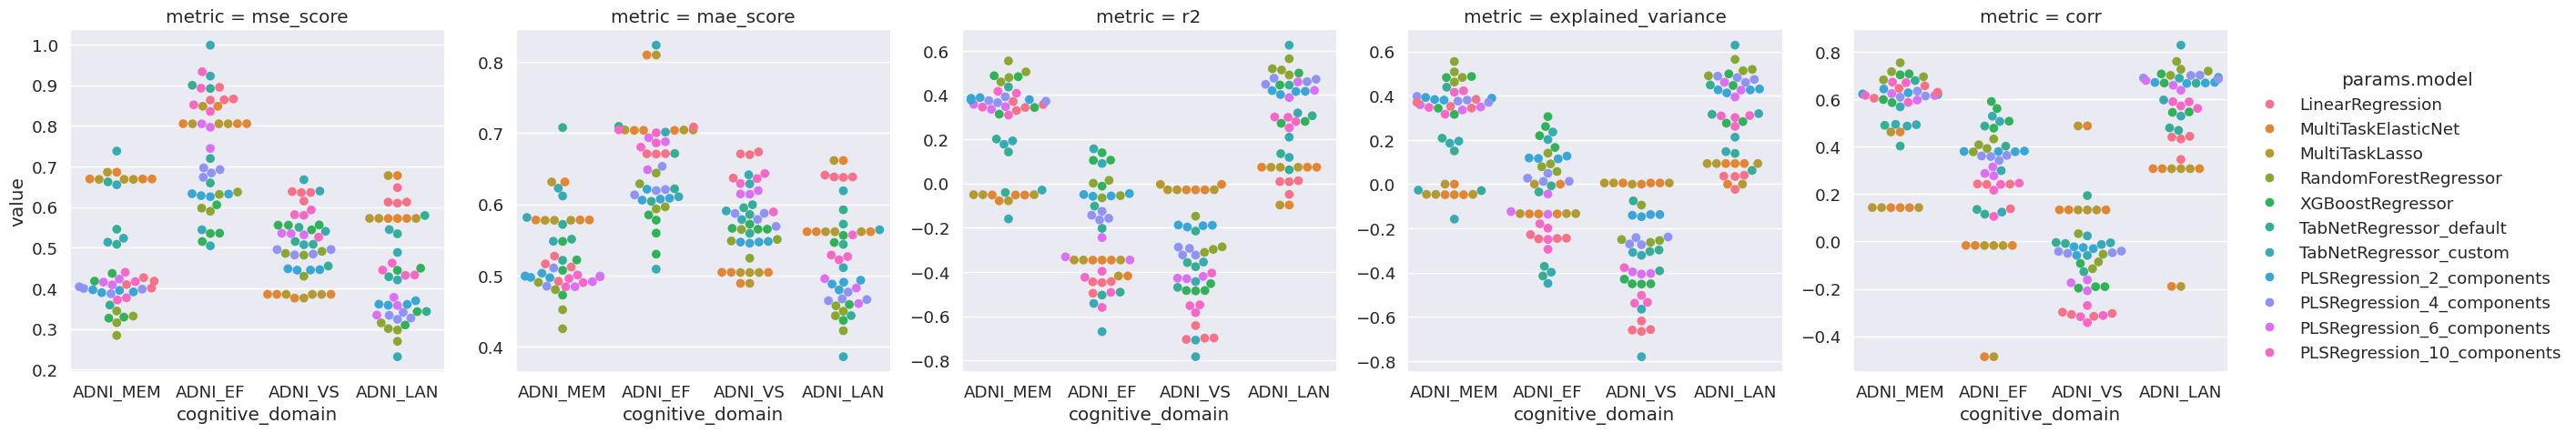

In [ ]:
df_plot_loonona_ajd = df_results_loonona_radar[df_results_loonona_radar['result_domain'] == "results_adj"]
df_plot_loonona_org = df_results_loonona_radar[df_results_loonona_radar['result_domain'] == "results_org"]

sns.catplot(data=df_plot_loonona_ajd, x="cognitive_domain", y="value", col = "metric", hue="params.model", kind="swarm", sharey=False, size=7,  aspect=1)

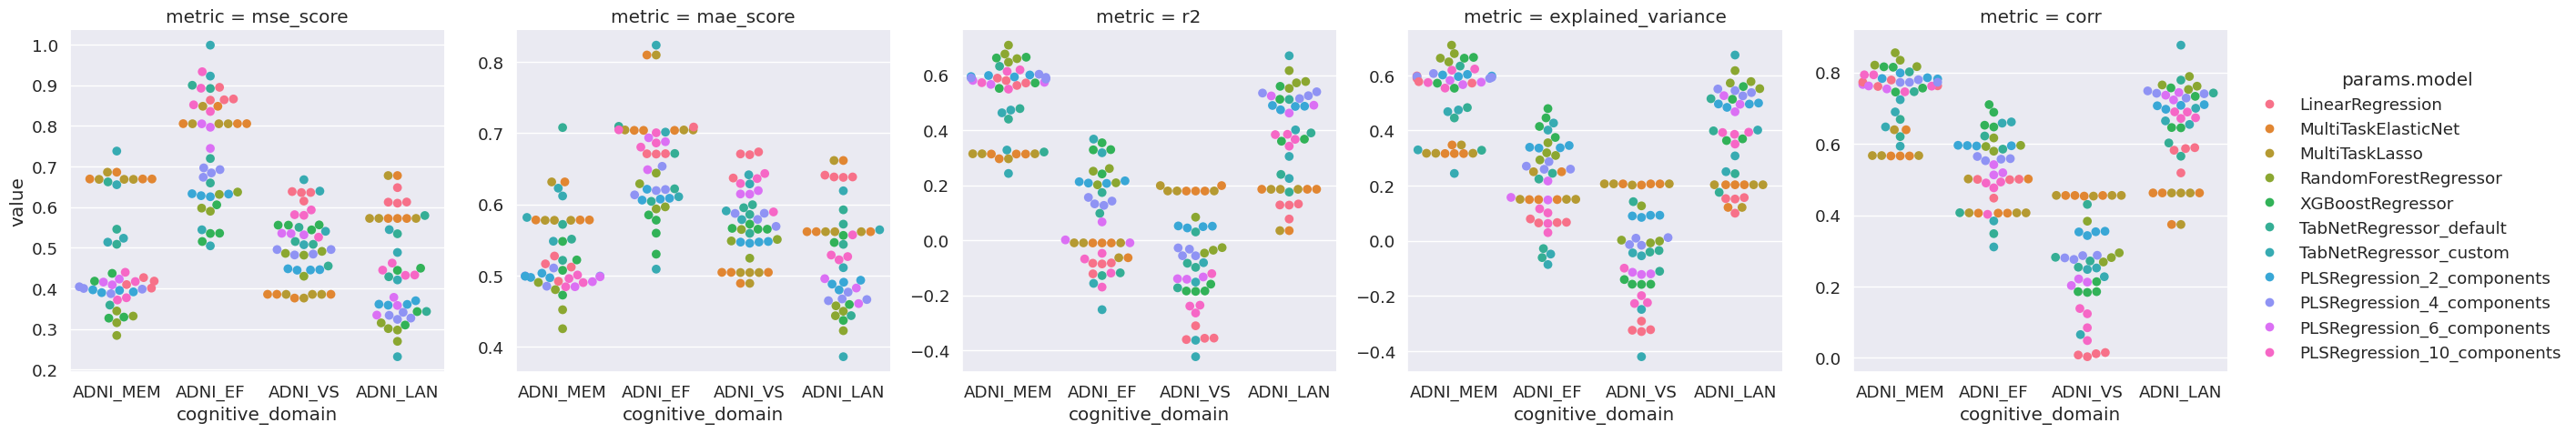

In [ ]:
sns.catplot(data=df_plot_loonona_org, x="cognitive_domain", y="value", col = "metric", hue="params.model", kind="swarm", sharey=False, size=7,  aspect=1)